In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print(data.info())

#Check Null/NaN Values
print(data.isnull().sum())

#Drop customerID since it's irrelevant
data.drop('customerID',axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
#Display all object types and describe them
data.astype('object').describe().T

,count,unique,top,freq
gender,7043,2,Male,3555
SeniorCitizen,7043,2,0,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
tenure,7043,73,1,613
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


In [ ]:
#Convert Total Charges from Object to Int
pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').convert_dtypes()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


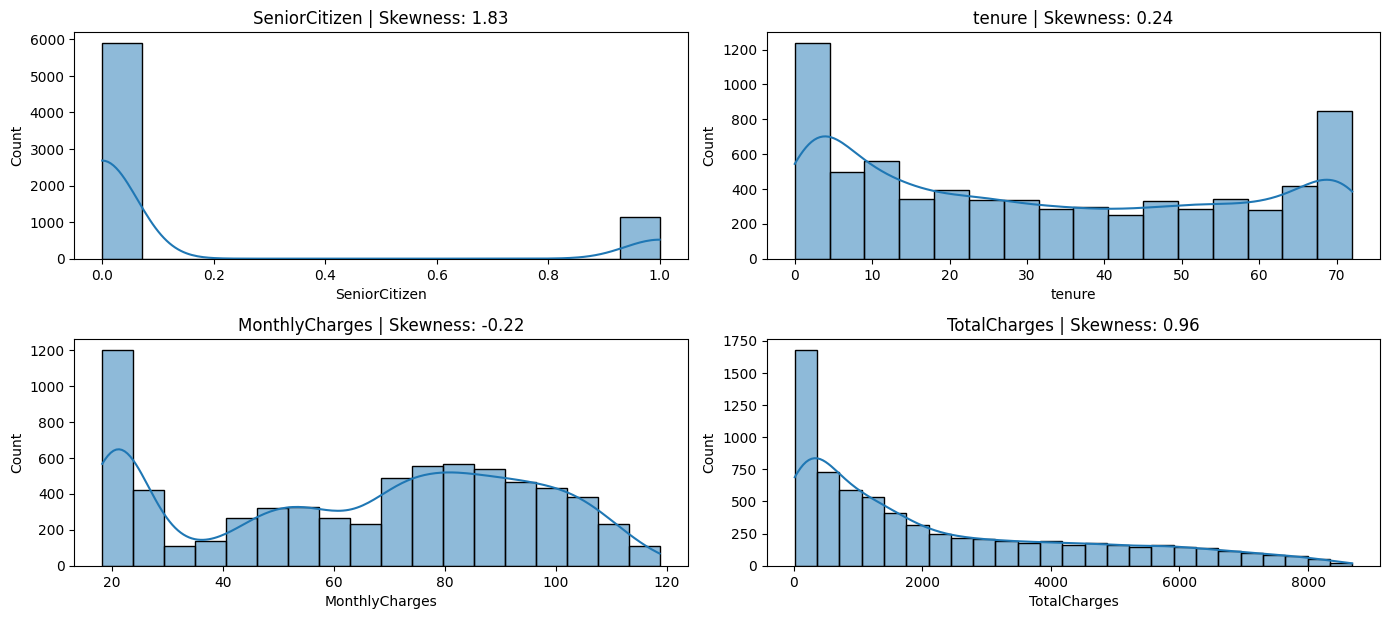

In [ ]:
numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns

# Plot distribution of each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(data[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(data[feature].skew(), 2)}")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

<Axes: >

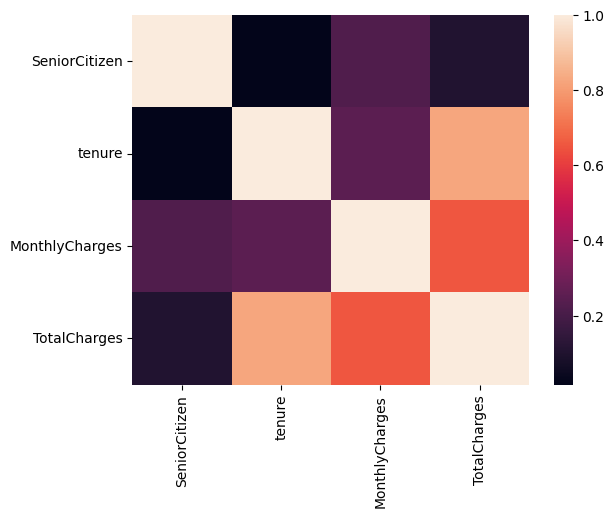

In [ ]:
sns.heatmap(data[numerical_columns].corr()) #Correlation among numerical values

In [ ]:
text_data = data.select_dtypes(exclude=["int64", "float64"]).columns  #All Categorical Columns
text_data

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

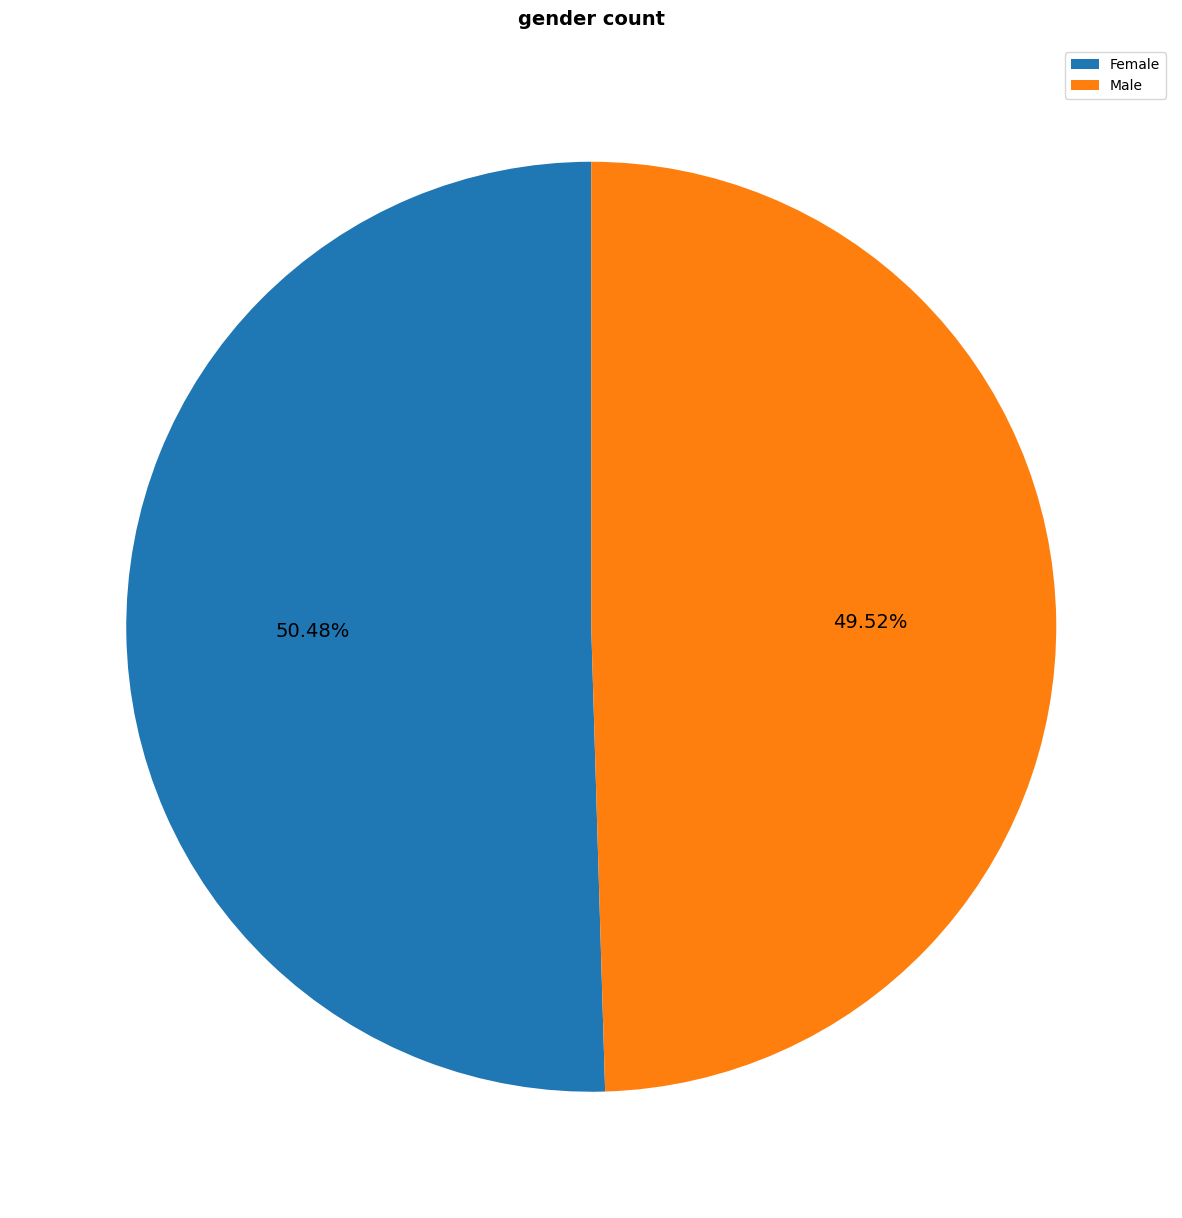

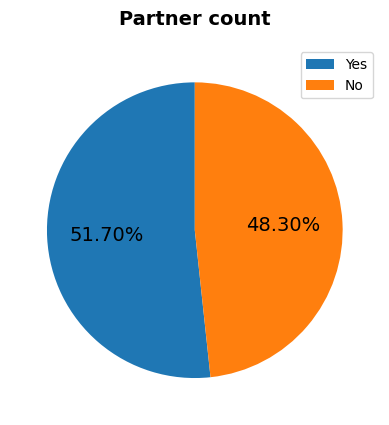

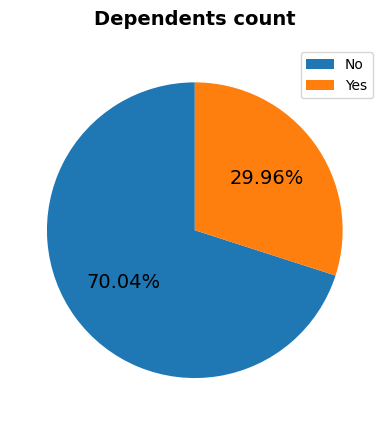

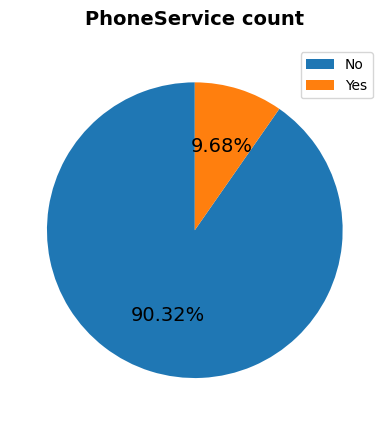

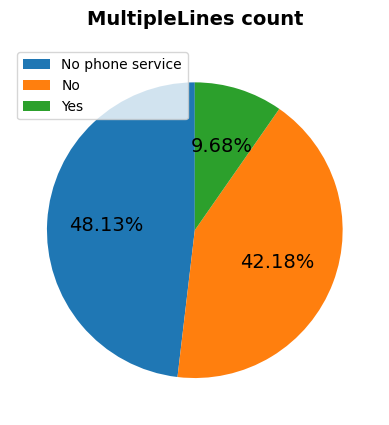

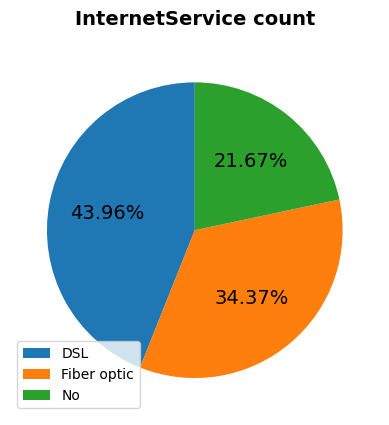

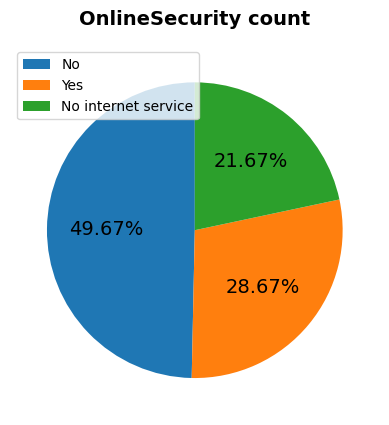

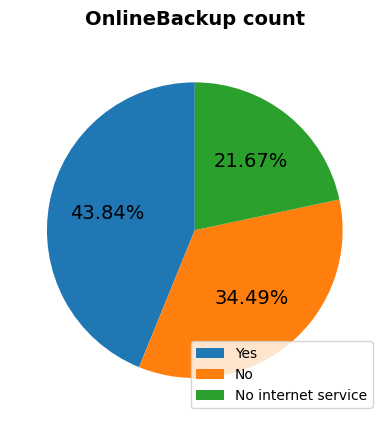

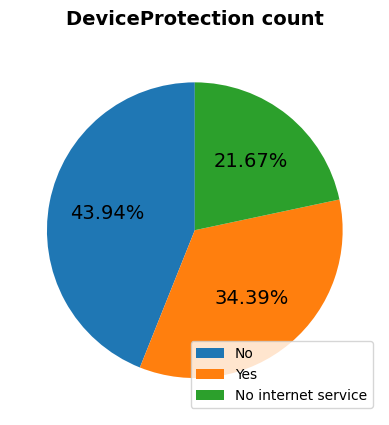

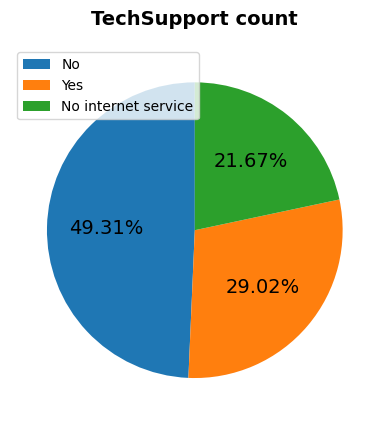

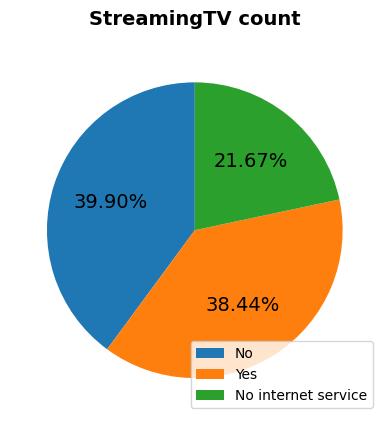

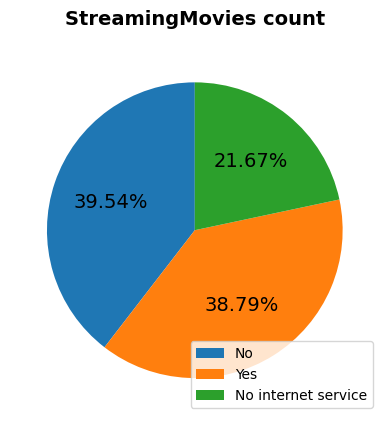

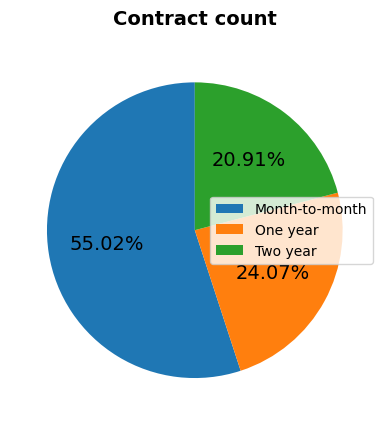

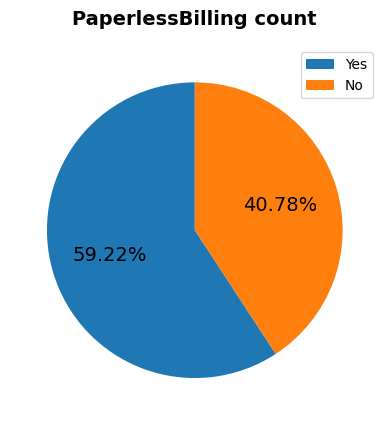

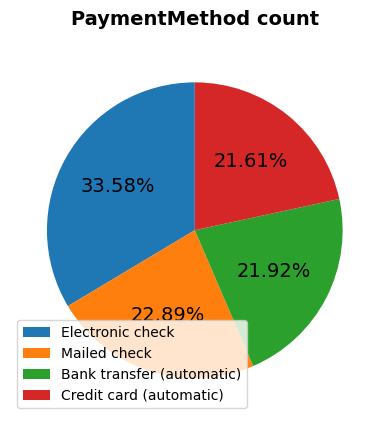

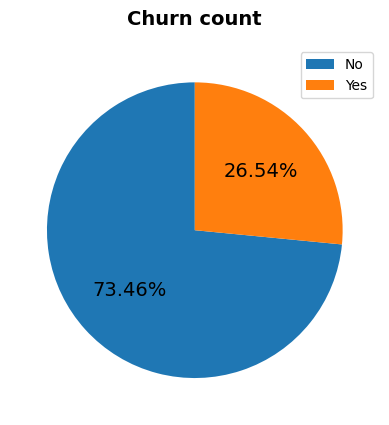

In [ ]:
col_count = len(text_data)
plt.figure(figsize=(15, 5*col_count))
i=1

for x in text_data:
  data_count = data[x].value_counts()

  #Pie Plots to understand categorical types and splits in each category
  patches = plt.pie(data_count, autopct="%.2f%%", textprops={"size": 14,}, startangle=90)
  center_circle = plt.Circle((0, 0), 0.3, fc='white')
  plt.title("{} count".format(x), fontweight="black", size=14, pad=15)
  plt.legend(data[x].unique(),loc="best")

  i=i+1
  plt.show()




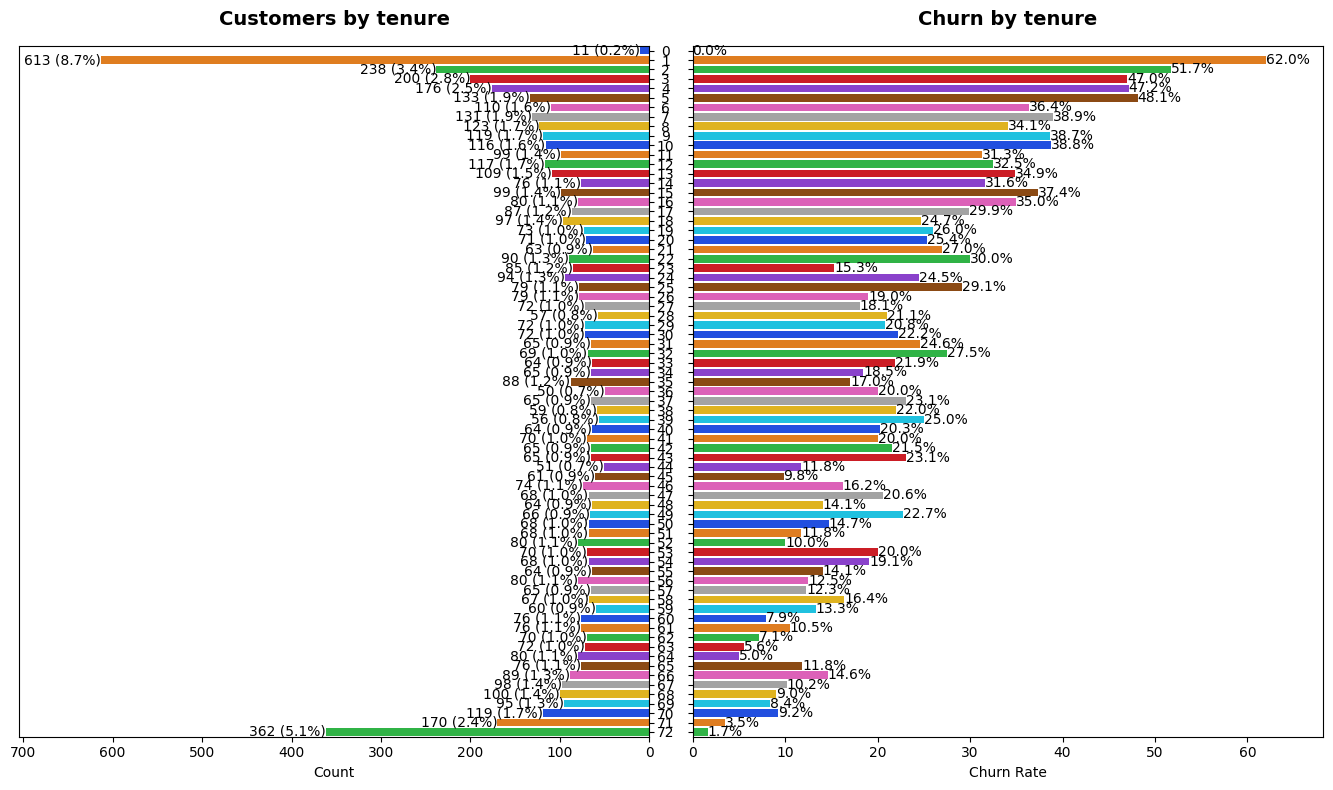

In [ ]:
#Tenure vs Churn Distribution


def count_percent_plot(df, col, target_col):
    value_1 = df[col].value_counts().sort_index()
    # Sort the values for the second subplot to match the order of the first subplot
    value_2 = df[df[target_col] == 'Yes'][col].value_counts().reindex(value_1.index)
    churn_rate = (value_2.fillna(0).values / value_1.values * 100)

    fig, axes = plt.subplots(ncols=2, figsize=(13.5, 8), sharey=True)

    t1 = sns.barplot(y=[i for i in range(len(value_1.index.astype("category")))], x=value_1.values, ax=axes[0], palette='bright', orient='h')
    t1.set_yticklabels(value_1.index.astype("category"), ha="center", position=(1.01,0)) # ha and position adjustments.
    t1.invert_xaxis()
    t1.yaxis.tick_right()
    axes[0].margins(x=0.15)
    axes[0].set_title(f"Customers by {col}", fontweight="black", size=14, pad=15)
    for index, value in enumerate(value_1.values):
        count_percentage = "{:.1f}%".format((value / len(df)) * 100)
        axes[0].text(value, index, f"{value} ({count_percentage})", ha="right", va="center", size=10)
    axes[0].set_xlabel('Count')


    t2 = sns.barplot(y=[i for i in range(len(value_1.index.astype("category")))], x=churn_rate, ax=axes[1], palette='bright', orient='h')
    t2.set_yticklabels(value_1.index.astype("category"), ha="center", position=(1.,0)) # ha and position adjustments.
    axes[1].margins(x=0.1)
    axes[1].set_title(f"Churn by {col}", fontweight="black", size=14, pad=15)
    for index, value in enumerate(churn_rate):
        churn_percentage = "{:.1f}%".format(np.round(churn_rate[index], 1))
        axes[1].text(value, index, churn_percentage, ha="left", va="center", size=10)
    axes[1].set_xlabel(f"{target_col} Rate")
    axes[1].set_ylabel(col)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


count_percent_plot(data, 'tenure', 'Churn')

In [ ]:
#Import Label Encoder

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#Convert Categorical Values into Encodede forms
data[text_data] = data[text_data].apply(le.fit_transform)

In [ ]:
data.shape

(7043, 20)

<Axes: title={'center': 'Correlation Plot'}>

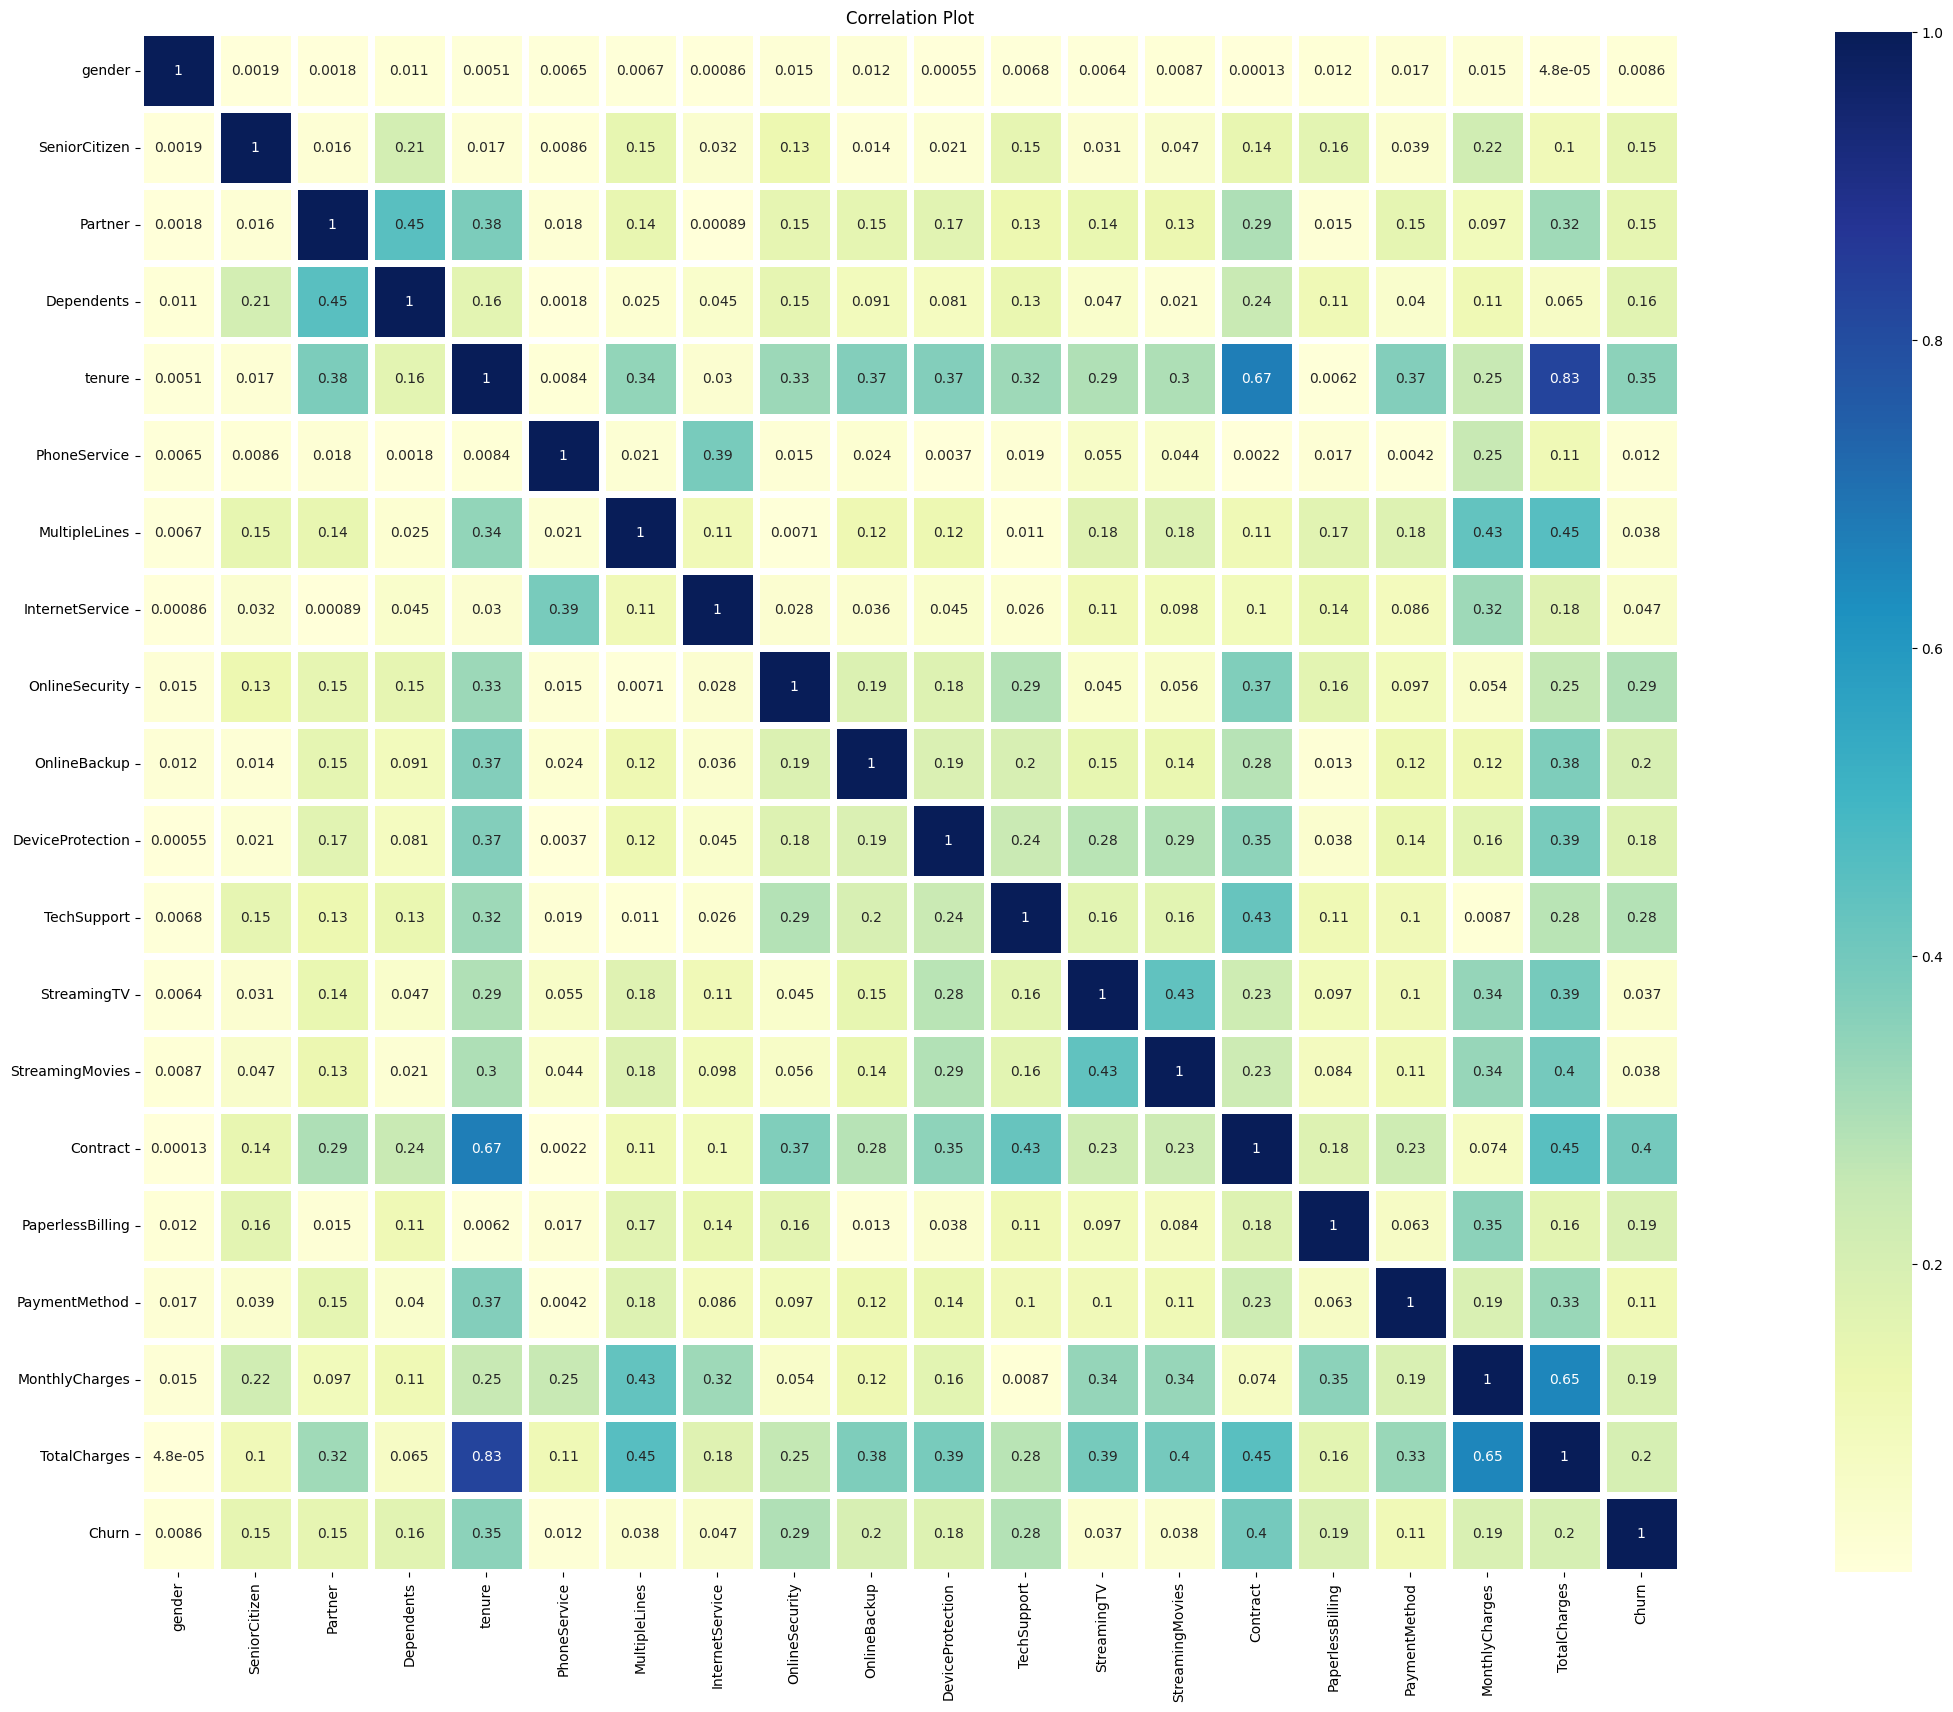

In [ ]:
#Heatmap to show correlation among categorical data

plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(np.abs(data.corr()),linewidths=5, annot=True, square=True,annot_kws={'size': 10},cmap='YlGnBu')

In [ ]:
#Specify Data into X(Features) and Y(Target)

X = data.loc[:,data.columns!='Churn']
y = data['Churn']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Split data in Train:Test = 0.75:0.25 Ratio
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
#Specify Parameters for GridSearchCV

params = {
    'max_depth': [3, 6, 15],
  'learning_rate': [0.1, 0.2, 0.3],
  'n_estimators': [150, 250, 500],
  'num_class': [10,20,30]
}

In [25]:
#Use GridSearchCV for fine-tuning

model = XGBClassifier(objective="multi:softmax", tree_method='hist', device="cuda")
clf = GridSearchCV(estimator=model,
                             param_grid=params,
                             scoring='accuracy',
                             n_jobs=4,
                             verbose=1)
clf.fit(X_train, y_train)

best_combination = clf.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [26]:
#Get the best paramters

best_combination

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'num_class': 10}

In [28]:
#Use the best paramters

best_model = XGBClassifier(learning_rate = 0.1,
                           max_depth = 3,
                           n_estimators = 150,
                           num_class = 10,
                           objective="multi:softmax",
                           tree_method='hist',
                           device="cuda")
best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)

In [34]:
#Print Classification Metrics

print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("Recall: ",recall_score(y_test,y_pred))
print("F1-Score: ",f1_score(y_test,y_pred))
print("Receiver Operating Characteristic Curve: ",roc_auc_score(y_test,y_pred))

Accuracy:  0.7915956842703009
Precision:  0.6382428940568475
Recall:  0.5210970464135021
F1-Score:  0.5737514518002322
Receiver Operating Characteristic Curve:  0.7061584688166966
